# Protein Language Models Contextually Prefer PUMA Siblings

<img src="../figures/experiment_esm_flow.svg" alt="Protein Language Models Contextually Prefer PUMA Siblings" width="1200">

Schematic of the ESM-2 masked-unit analysis for validating the contextual plausibility of PUMA-defined mutations. From an original protein unit (e.g., *CSK* in *ELCSKAF*), two variants are created: (1) a Mutated sequence using a PUMA-defined sibling unit (e.g., *CSA*) and (2) an Alternative sequence using a high-scoring, non-sibling unit from the vocabulary (e.g., *CSR*). The differing amino acid position is masked in the original sequence (e.g., *ELCS[MASK]AF*) and evaluated by the ESM-2 model. The model's output logits for the sibling-derived amino acid $L\left(A\mid\left[MASK\right]\right)$ and the alternative amino acid $L\left(R\mid\left[MASK\right]\right)$ are compared to determine which substitution is more contextually plausible.

---

In this experiment, we assessed whether ESM-2 contextually prefers PUMA-defined mutations over other high-scoring alternatives. We hypothesized that PUMA siblings represent more biologically plausible substitutions.

The workflow compares two modified sequences:
* **Mutated Sequence:** Created by substituting a protein unit with a PUMA-defined mutational sibling.
* **Alternative Sequence:** Created by substituting the same unit with a high-scoring alternative. To ensure a rigorous comparison, alternatives are required to be present in the PUMA vocabulary, match or exceed the sibling's substitution score, and be added to the vocabulary later than the mutated unit to preclude close genealogical ties.

Using a masked prediction task with ESM-2 650M, we compared output logits for sibling-derived versus alternative-derived residues. 

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["HF_HOME"] = "/cta/share/users/esm"

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from Bio.Align import substitution_matrices
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import random
from time import time
import sqlite3

from vocabulary_functions import load_tokenizers, vocabulary_lineage_builder
from experiment_esm_functions import precompute_alternatives, run_mutation_experiment_optimized, run_enhanced_protein_similarity_experiment

## Experiment Setup and Data Loading



We utilize the **UniRef50** dataset, distilled for human proteins. The proteins are filtered to a length of less than 1000 amino acids to ensure efficient processing.



PUMA initializes its vocabulary with standard amino acids and iteratively builds larger protein units based on co-occurrence frequencies. To validate this structure, we load protein sequences that will be tokenized using various PUMA vocabulary configurations.

In [3]:
# Connect to DB
db_file = "/cta/share/users/uniprot/human/human.db"
conn = sqlite3.connect(db_file)

uniref_id = '50'
df_protein = pd.read_sql(f"""SELECT Entry as uniprot_id, Sequence as sequence
                          FROM proteins
                          WHERE Entry IN (SELECT uniprot_accession FROM uniref{uniref_id}_distilled)""", conn)
df_protein = df_protein[df_protein['sequence'].str.len() < 1000].reset_index(drop=True)

conn.close()

## Tokenizer Configuration and Vocabulary Loading



We evaluate PUMA across a grid of hyperparameters to understand how vocabulary construction affects biological plausibility:

* **Substitution Matrices:** BLOSUM45, BLOSUM62, PAM70, PAM250.

* **Alignment Score Cut-off ($a$):** 0.7, 0.8, 0.9.

* **Minimum Mutation Frequency ($f$):** 0, 0.005, 0.05, 0.1, 0.2.

* **Vocabulary Sizes:** From 800 to 51,200 units.



Each configuration produces a unique genealogical tree of protein units (parents, children, siblings). We load these tokenizers and their lineage maps to identify "siblings" for the mutation experiment.

In [ ]:
# 'dataset': {'uniref50', 'uniref90'}
# 'is_pretokenizer': {True, False}
# 'subs_matrix': {'blosum45', 'blosum62', 'pam70', 'pam250'}
# 'mutation_cutoff': {0.7, 0.8, 0.9}
# 'min_mutation_freq': {0, 0.005, 0.05, 0.1, 0.2}
# 'min_mutation_len': {3}
# 'max_mutation_len': {12}
# 'vocab_size': list=[800, 1600, 3200, 6400, 12800, 25600, 51200]

# vocab_sizes = [12800, 51200]
# uniref_id = "50"

# tokenizer_opts_list = [
#     {
#         'is_mut': True,
#         'dataset': f'uniref{uniref_id}',
#         'is_pretokenizer': False,
#         'subs_matrix': 'blosum62',
#         'mutation_cutoff': 0.7,
#         'min_mutation_freq': 0.05,
#         'min_mutation_len': 3,
#         'max_mutation_len': 12,
#         'vocab_size': vocab_sizes
#     },
#     {
#         'is_mut': True,
#         'dataset': f'uniref{uniref_id}',
#         'is_pretokenizer': False,
#         'subs_matrix': 'pam70',
#         'mutation_cutoff': 0.7,
#         'min_mutation_freq': 0.05,
#         'min_mutation_len': 3,
#         'max_mutation_len': 12,
#         'vocab_size': vocab_sizes
#     }
# ]

tokenizer_opts_list = []

vocab_sizes = [800, 1600, 3200, 6400, 12800, 25600, 51200]
uniref_id = "50"

for subs_matrix in ['blosum45', 'blosum62', 'pam70', 'pam250']:
    for mutation_cutoff in [0.7, 0.8, 0.9]:
        for min_mutation_freq in [0, 0.005, 0.05, 0.1, 0.2]:
            if subs_matrix == 'pam250' and mutation_cutoff == 0.7:
                continue
            tokenizer_opts_list.append(
                {
                    'is_mut': True,
                    'dataset': f'uniref{uniref_id}',
                    'is_pretokenizer': False,
                    'subs_matrix': subs_matrix,
                    'mutation_cutoff': mutation_cutoff,
                    'min_mutation_freq': min_mutation_freq,
                    'min_mutation_len': 3,
                    'max_mutation_len': 12,
                    'vocab_size': vocab_sizes
                }
            )

In [ ]:
tokenizer_list = load_tokenizers(tokenizer_opts_list, 'hf')
inner_vocab_list = load_tokenizers(tokenizer_opts_list, 'vocab')

vocab_list = {name: list(set(tok.get_vocab().keys())) for name, tok in tokenizer_list.items()}
methods = [name[:-len(str(vocab_sizes[0]))-1] for name in list(tokenizer_list.keys())[::len(vocab_sizes)]]
methods2names = {m: m.replace('blosum', 'BLOSUM').replace('pam', 'PAM') for m in methods}
methods2names = {k: f"{v.split()[0]}({', '.join(v.split()[1:])})" if 'PUMA' in v else v for k, v in methods2names.items()} 

vocab_lineage_list = vocabulary_lineage_builder(inner_vocab_list)


## Tokenization



All proteins are encoded using the loaded PUMA tokenizers. This step converts amino acid sequences into sequences of PUMA protein units, revealing the hierarchical structure inherent in the vocabulary.

In [ ]:
for name, tokenizer in tqdm(list(tokenizer_list.items())):
    df_protein[name] = [enc.tokens for enc in tokenizer.encode_batch(df_protein['sequence'])]
df_protein.head()

## Generating Experimental Sequences



This section executes the core logic of the experiment:

1.  **Pre-computation:** We build lookup tables for substitution matrices to efficiently find "Alternative" amino acids that have scores $\ge$ the PUMA sibling mutation.

2.  **Sequence Generation:** For each protein, we generate:

    * **Mutated Sequence:** Substitutes a unit with its PUMA sibling.

    * **Alternative Sequence:** Substitutes the same unit with a high-scoring, non-sibling alternative from the vocabulary.

    * **Baseline Sequence:** Random substitution (control).



`run_enhanced_protein_similarity_experiment` then uses **ESM-2** to calculate the probability of each amino acid at the differing position.

In [ ]:
# Initialize and run the experiment
print("Starting enhanced protein mutation analysis...")

# Precompute alternatives for all substitution matrices
sub_matrix_precomputed_alternatives = {}
for sub_matrix_name in ['blosum45', 'blosum62', 'pam70', 'pam250']:
    sub_matrix = substitution_matrices.load(sub_matrix_name.upper())
    sub_matrix_precomputed_alternatives[sub_matrix_name] = precompute_alternatives(sub_matrix)

In [ ]:
# Run mutation experiment with baseline
print("Running mutation experiment with baseline...")
df_protein_oma, change_counters, change_scores = run_mutation_experiment_optimized(
    df_protein.sample(100, random_state=42), tokenizer_list, vocab_lineage_list, sub_matrix_precomputed_alternatives, create_baseline=True
)

In [ ]:
    # Run enhanced similarity experiment
print("Running enhanced similarity experiment...")
results_df = run_enhanced_protein_similarity_experiment(
    df_protein_oma,
    tokenizer_list,
    batch_size=64,
    include_rank_analysis=True,
    include_baseline=True
)


## Results Analysis



We analyze the "Win Rates" of PUMA mutations against alternatives and baselines. A win rate > 0.5 indicates that ESM-2 assigns higher probability to the PUMA sibling than the competitor.



We perform data cleaning to remove invalid runs and calculate the win rate of mutations versus the original sequence.

In [ ]:
results_df['vocab_size'] = results_df['tokenizer'].apply(lambda x: int(x.split(' ')[-1]))
results_df['tokenizer_name'] = results_df['tokenizer'].apply(lambda x: ' '.join(x.split(' ')[:-1]))
results_df['rank_win_rate_mut_vs_org'] = results_df['rank_win_rate_vs_mut'].apply(lambda x: 1-x)

results_df = results_df.dropna()
results_df = results_df[(results_df['processed_proteins'] > 0) & (~results_df['tokenizer'].str.contains(' 0.9 '))]

### Win Rates Across PUMA Models



The following violin plot visualizes the distribution of win rates across vocabulary sizes.

* **Mutation vs Random (Yellow):** PUMA mutations consistently outperform random baselines.

* **Mutation vs Alternative (Blue):** Larger vocabularies shift the median win rate above 0.5, suggesting expanded genealogical structures better capture evolutionary relationships.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


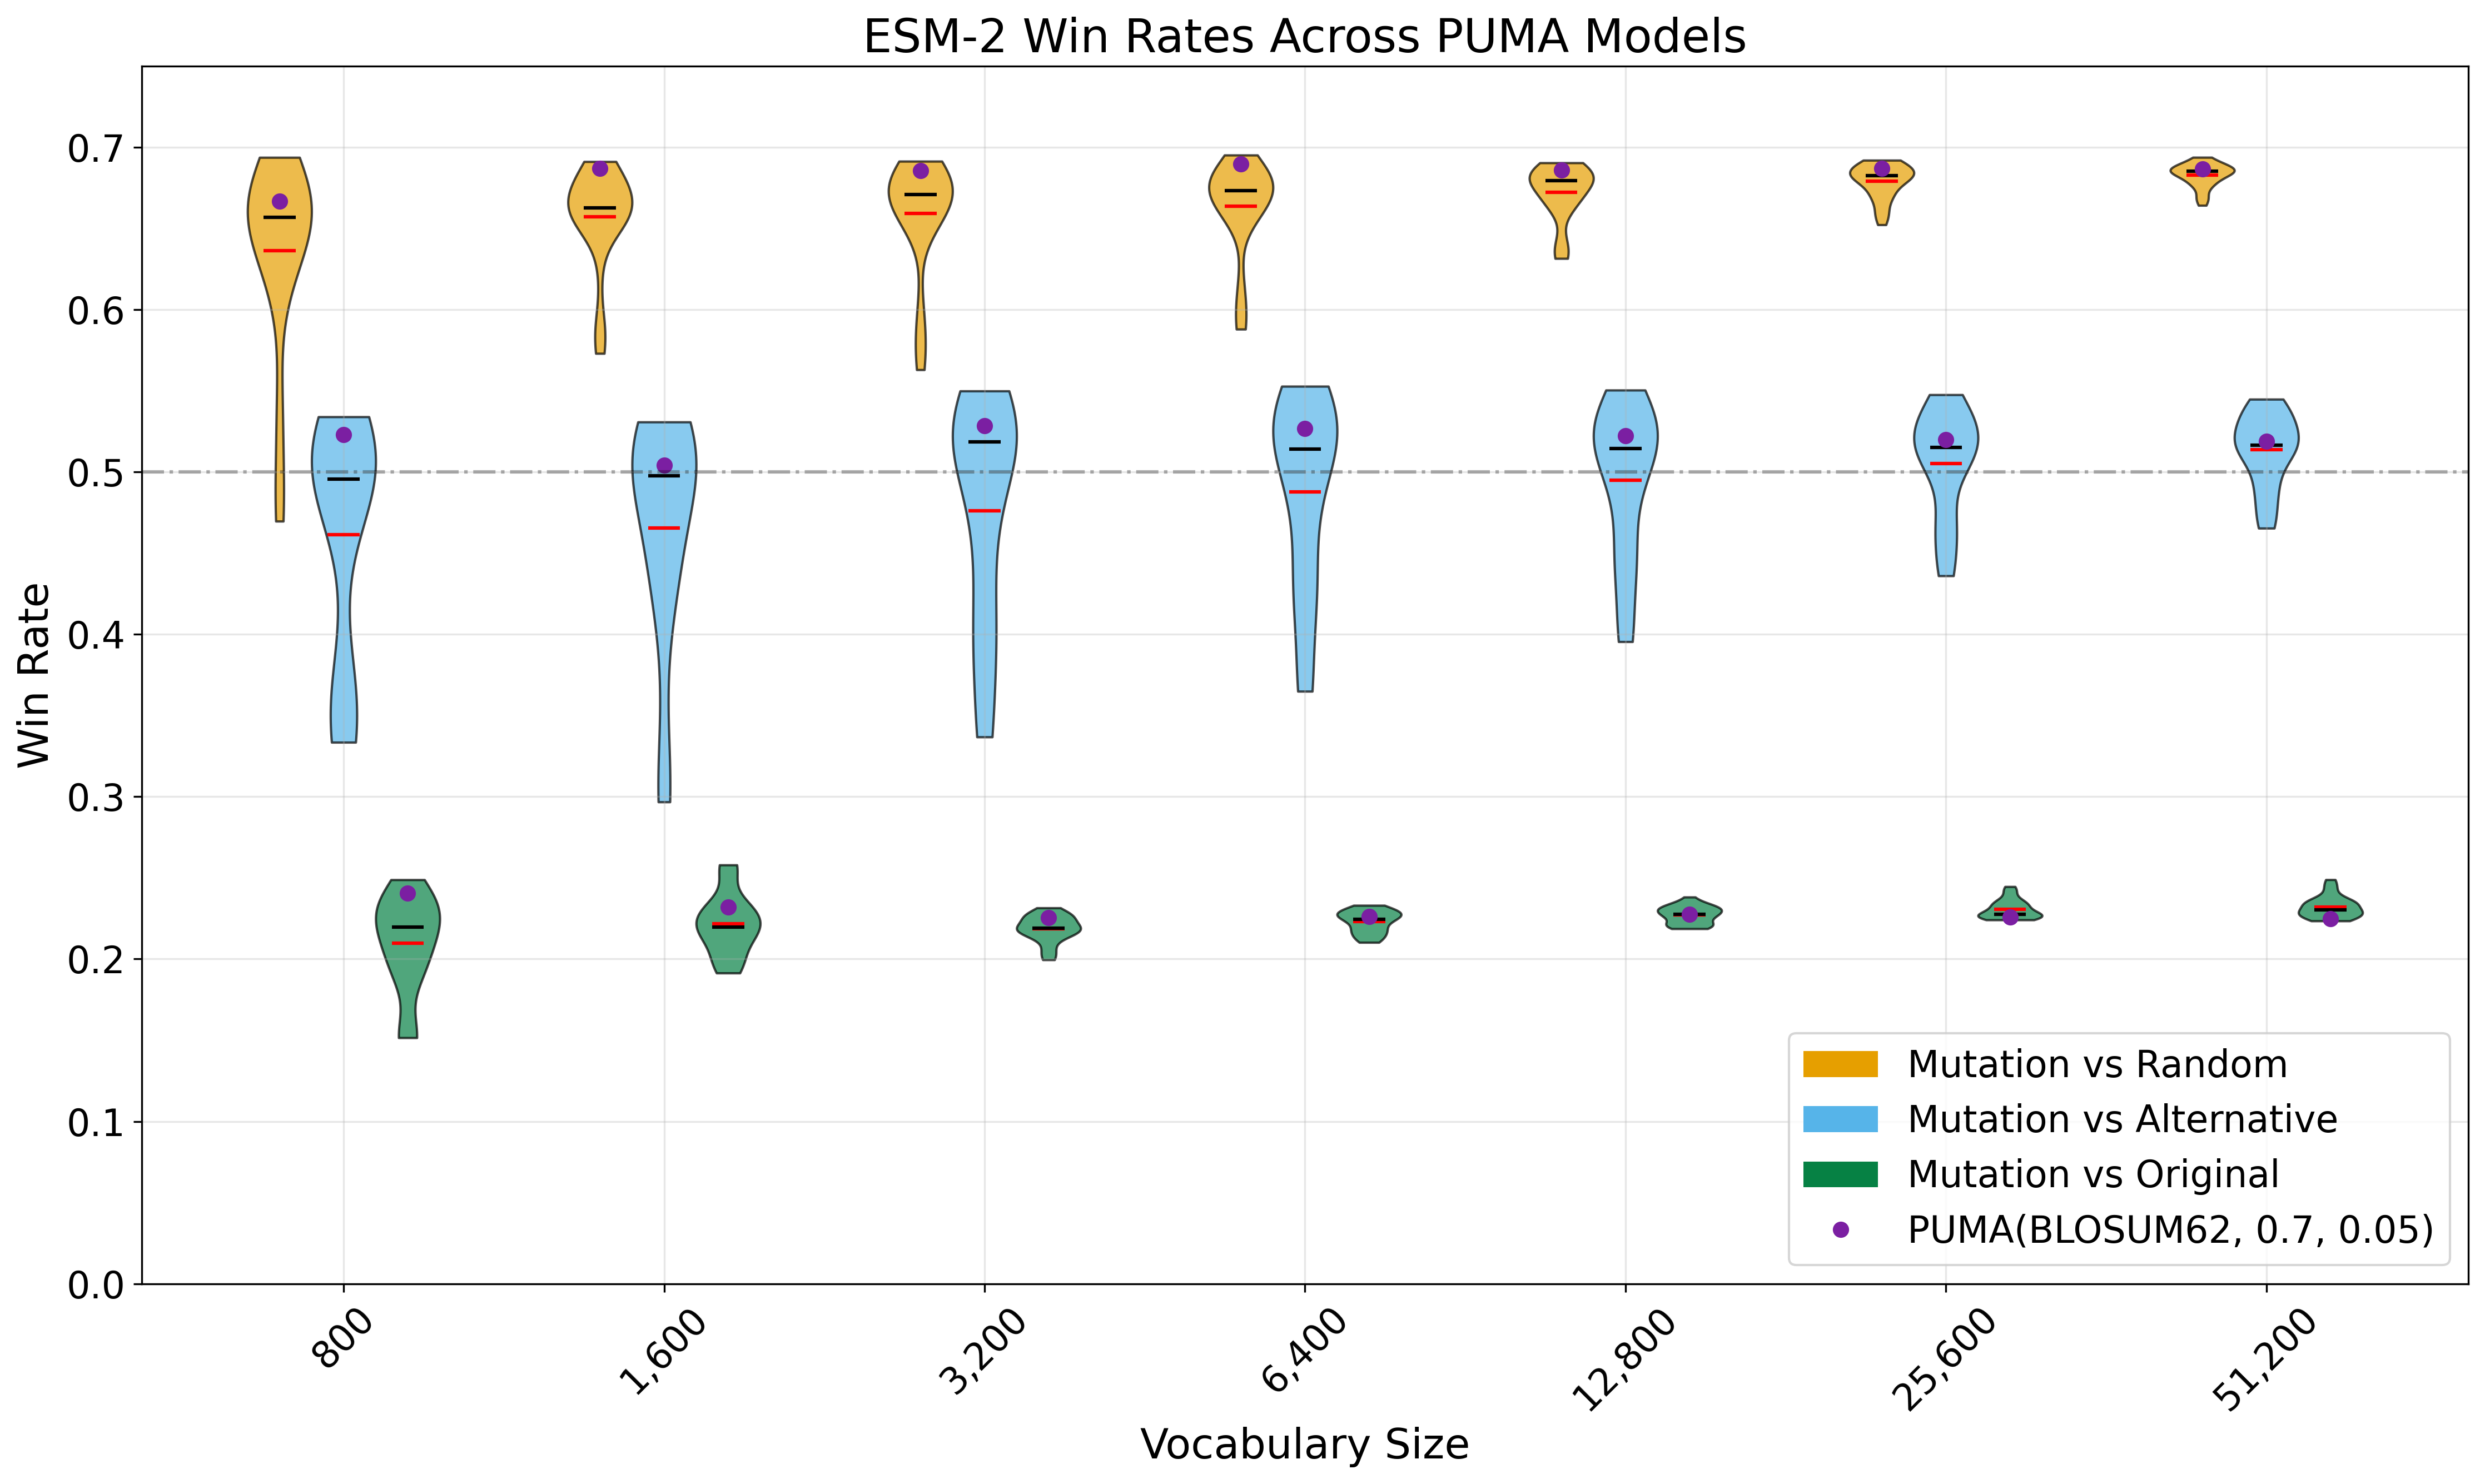

In [ ]:
fig, ax1 = plt.subplots(figsize=(15, 9))

colors = {
    "rank_win_rate_mut_vs_alt": "#56B4E9",
    "rank_win_rate_mut_vs_base": "#E69F00", 
    "rank_win_rate_mut_vs_org": "#068144"
}

offset = 0.2  # horizontal offset for separation
x_vals = sorted(results_df["vocab_size"].unique())
metrics = ['rank_win_rate_mut_vs_base', 'rank_win_rate_mut_vs_alt', 'rank_win_rate_mut_vs_org']
metrics2label = {
    "rank_win_rate_mut_vs_base": "Mutation vs Random",
    "rank_win_rate_mut_vs_alt": "Mutation vs Alternative",
    "rank_win_rate_mut_vs_org": "Mutation vs Original"
    }

for i, metric in enumerate(metrics):
    for j, ((v_size, ), final_group) in enumerate(results_df.groupby(["vocab_size"])):
        vals = final_group[metric].values
        
        # plot violin, shifted for visibility
        parts = ax1.violinplot(
            vals,
            # positions=[i],  # shift left/center/right
            positions=[j + (i - 1) * offset],
            widths=0.2,
            showmeans=True,
            showmedians=True,
            showextrema=False
        )
        # colorize
        for pc in parts['bodies']:
            pc.set_facecolor(colors[metric])
            pc.set_edgecolor("black")
            pc.set_alpha(0.7)
        if 'cmedians' in parts:
            parts['cmedians'].set_color("black")
        if 'cmeans' in parts:
            parts['cmeans'].set_color("red")

# --- labels, legend, cosmetics ---
ax1.set_xticks(range(len(x_vals)))
ax1.set_xticklabels([f"{v:,}" for v in x_vals], rotation=45, ha="center")
ax1.tick_params(axis='both', labelsize=16)
ax1.set_xlabel("Vocabulary Size", fontsize=18)
ax1.set_ylabel("Win Rate", fontsize=18)
ax1.set_ylim(bottom=0, top=0.75)
ax1.set_title("ESM-2 Win Rates Across PUMA Models", fontsize=20)
ax1.grid(True, alpha=0.3)

# --- overlay line aligned with 2nd violin group ---
method = 'PUMA blosum62 0.7 0.05'
for i, metric in enumerate(metrics):
    positions = [j + (i - 1) * offset for j in range(len(vocab_sizes))]
    line_vals = [results_df[results_df['tokenizer'] == f'{method} {vocab_size}'][metric].mean() for vocab_size in vocab_sizes]
    (line_handle,) = ax1.plot(positions, line_vals, 'o', color='#7B1FA2', markersize=6, label=methods2names[method])

ax1.axhline(y=0.5, color='k', linestyle='-.', linewidth=1.5, alpha=0.3)

# custom legend
legend_handles = [Patch(facecolor=colors[m], label=metrics2label[m]) for m in metrics]
legend_handles.append(line_handle)  # add the purple line handle
ax1.legend(handles=legend_handles, loc='lower right', fontsize=16)

plt.tight_layout()
plt.rcParams['figure.dpi'] = 300
plt.savefig("figures/esm_all_win_rates.eps")
plt.savefig("figures/esm_all_win_rates.png")
plt.show()

### Impact of Alignment Score Cut-off



Here we compare models with alignment score cut-offs of 0.7 vs 0.8.



* **0.7 Cut-off (Blue):** Win rates are consistently above 0.5. This cut-off absorbs borderline candidates as siblings, leaving weaker units as "Alternatives".

* **0.8 Cut-off (Yellow):** Win rates drop below 0.5. A stricter cut-off excludes high-scoring variants from the family, making them available as strong external "Alternatives" that outperform the siblings.



This validates that the 0.7 cut-off yields a more robust and contextually accurate genealogical organization.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


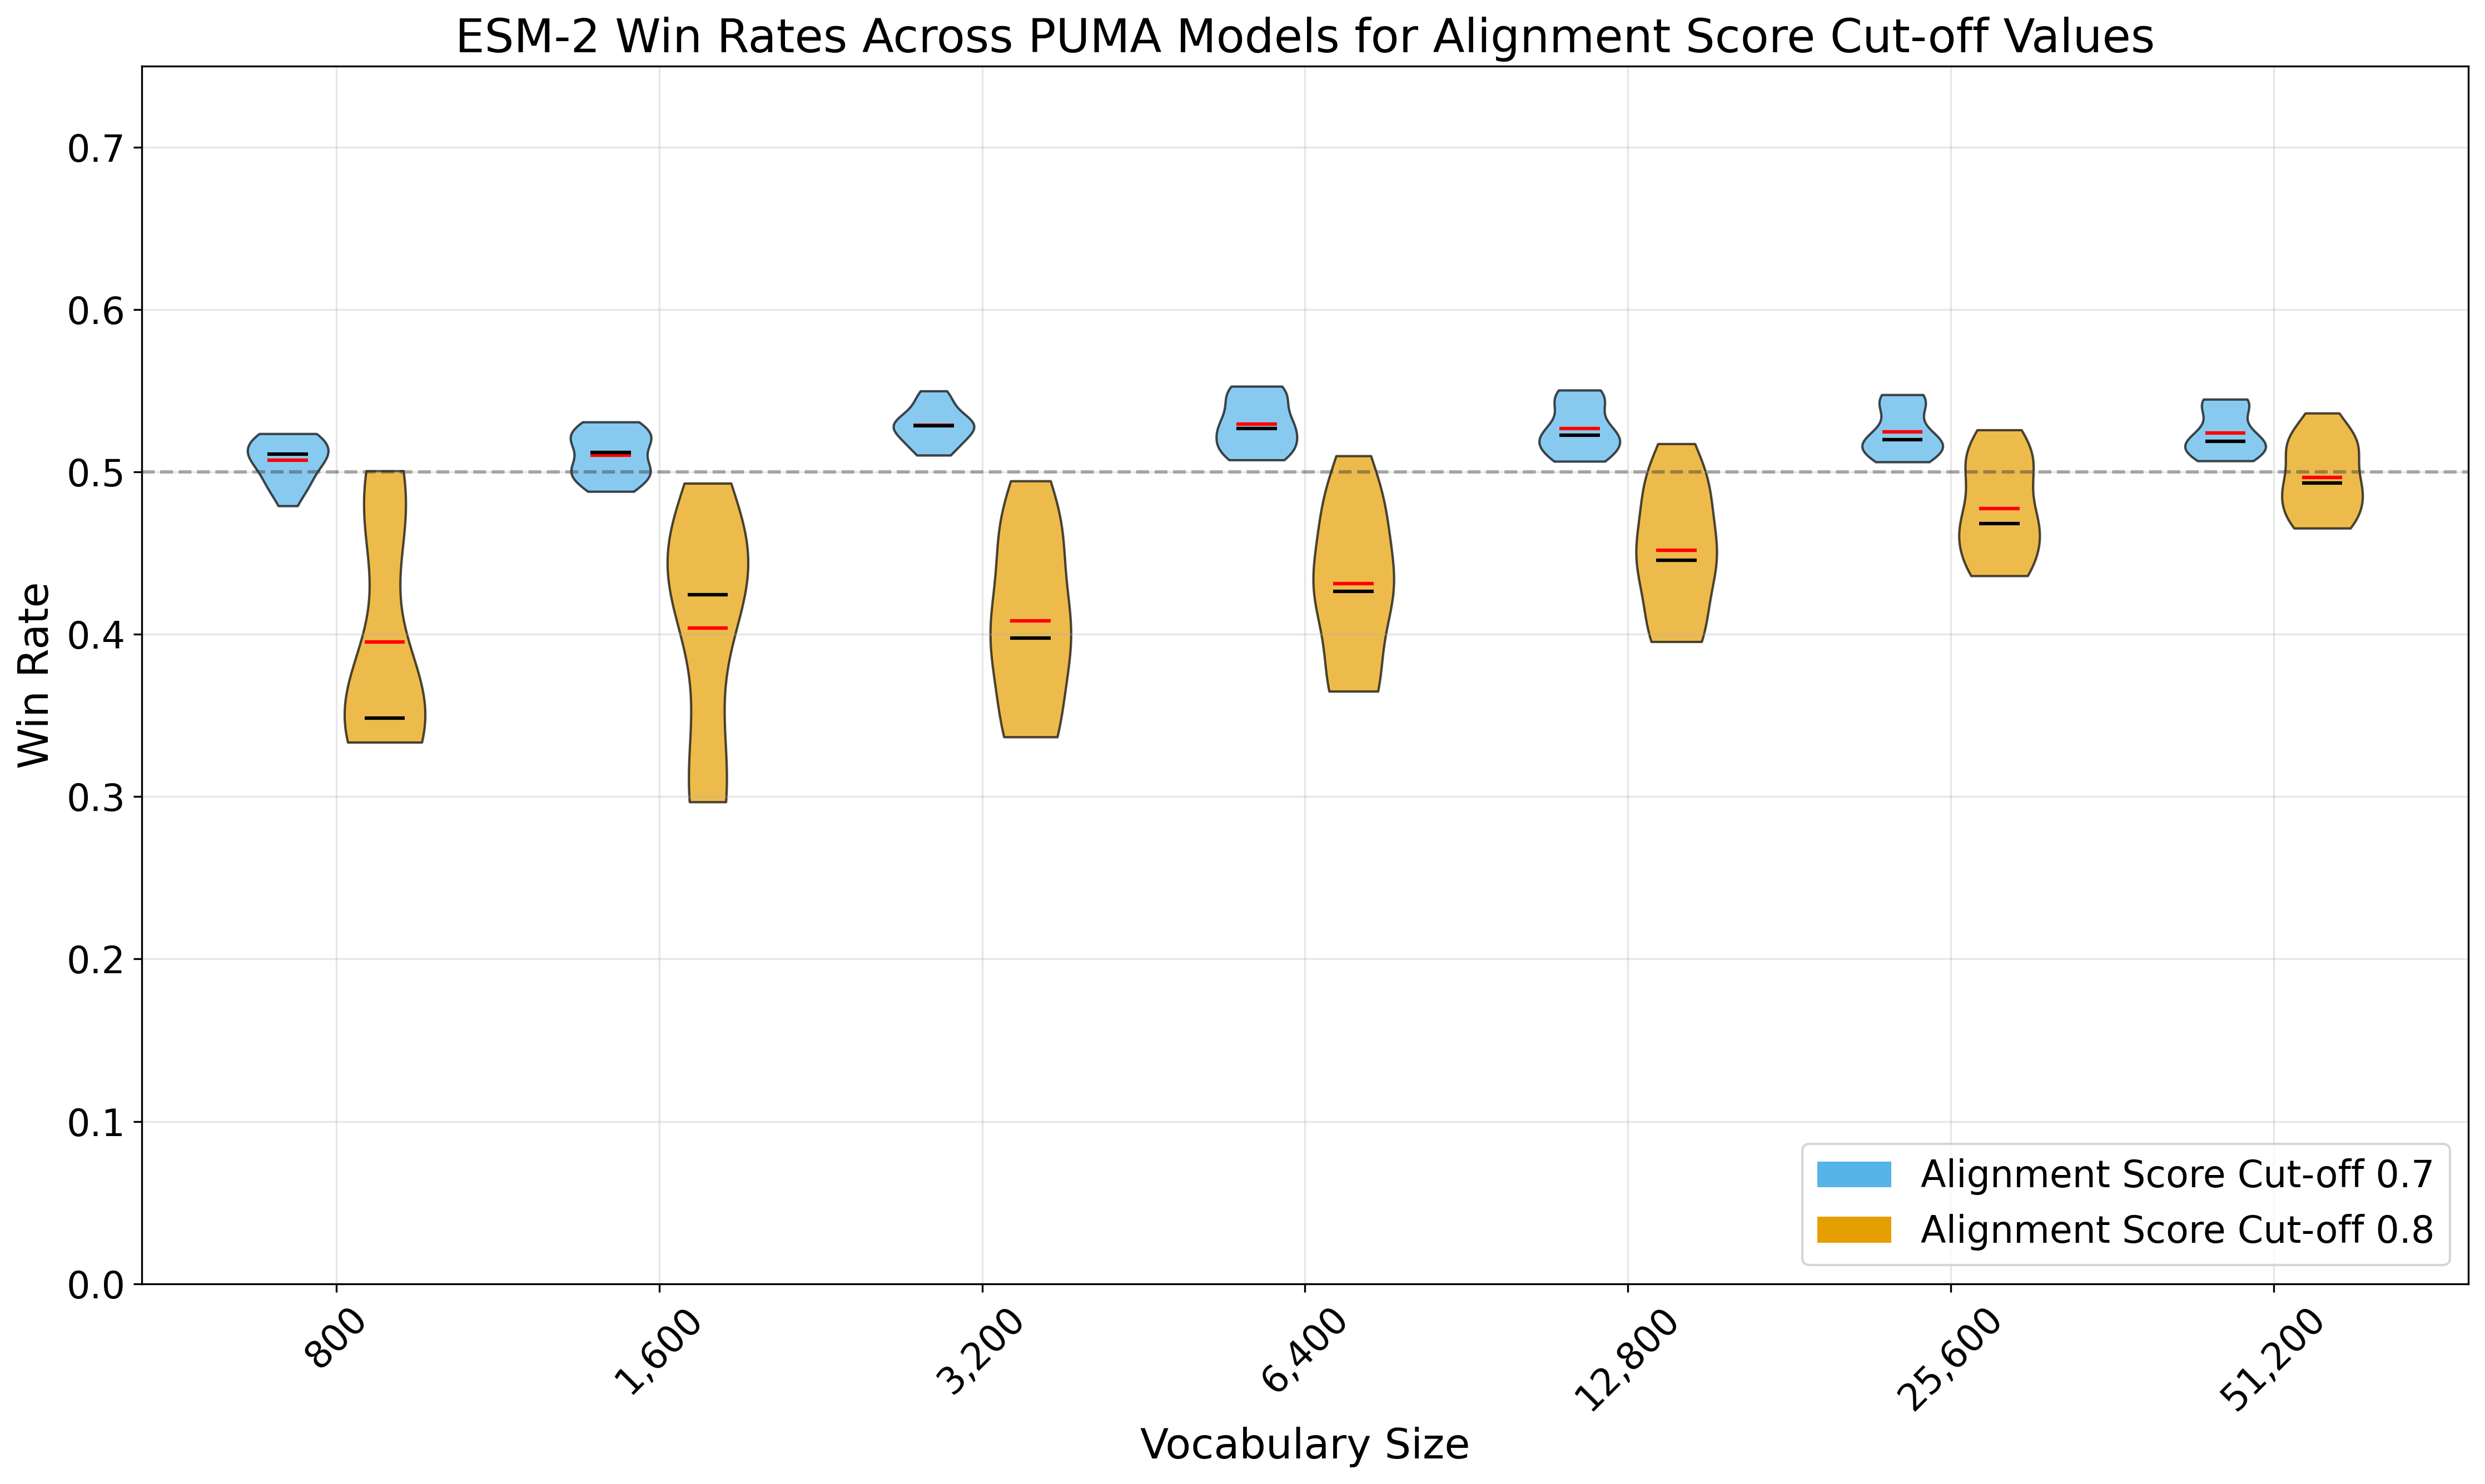

In [ ]:
fig, ax1 = plt.subplots(figsize=(15, 9))

colors = {
    "0.7": "#56B4E9",
    "0.8": "#E69F00", 
}

offset = 0.3  # horizontal offset for separation
x_vals = sorted(results_df["vocab_size"].unique())
metrics2label = {
    "rank_win_rate_mut_vs_alt": "Mutation vs Alternative"
    }
metric = 'rank_win_rate_mut_vs_alt'

for i, thr in enumerate([' 0.7 ', ' 0.8 ']):
    df_filtered = results_df[(results_df['tokenizer'].str.contains(thr)) & ~(results_df['tokenizer'].str.contains('pam250'))]
    for j, ((v_size, ), final_group) in enumerate(df_filtered.groupby(["vocab_size"])):
        vals = final_group[metric].values

        # plot violin, shifted for visibility
        parts = ax1.violinplot(
            vals,
            # positions=[i],  # shift left/center/right
            positions=[j + (i - 0.5) * offset],
            widths=0.25,
            showmeans=True,
            showmedians=True,
            showextrema=False
        )
        # colorize
        for pc in parts['bodies']:
            pc.set_facecolor(colors[thr.strip()])
            pc.set_edgecolor("black")
            pc.set_alpha(0.7)
        if 'cmedians' in parts:
            parts['cmedians'].set_color("black")
        if 'cmeans' in parts:
            parts['cmeans'].set_color("red")

# --- labels, legend, cosmetics ---
ax1.set_xticks(range(len(x_vals)))
ax1.set_xticklabels([f"{v:,}" for v in x_vals], rotation=45, ha="center")
ax1.tick_params(axis='both', labelsize=16)
ax1.set_xlabel("Vocabulary Size", fontsize=18)
ax1.set_ylabel("Win Rate", fontsize=18)
ax1.set_ylim(bottom=0, top=0.75)
ax1.set_title("ESM-2 Win Rates Across PUMA Models for Alignment Score Cut-off Values", fontsize=20)
ax1.grid(True, alpha=0.3)

ax1.axhline(y=0.5, color='k', linestyle='--', linewidth=1.5, alpha=0.3)

legend_handles = [Patch(facecolor=colors[thr], label=f'Alignment Score Cut-off {thr}') for thr in ['0.7', '0.8']]

ax1.legend(handles=legend_handles, loc='lower right', fontsize=16)

plt.tight_layout()
plt.rcParams['figure.dpi'] = 300
plt.savefig("figures/esm_alignment_win_rates.eps")
plt.savefig("figures/esm_alignment_win_rates.png")
plt.show()